In [2]:
!pip install adversarial-robustness-toolbox;

In [3]:
%matplotlib inline 

from __future__ import absolute_import, division, print_function, unicode_literals
from os.path import abspath
import os
import time
import sys
sys.path.append(abspath('.'))
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from art.classifiers import KerasClassifier

import art
from art.attacks import DeepFool, BasicIterativeMethod, FastGradientMethod, SaliencyMapMethod, CarliniL2Method, NewtonFool, UniversalPerturbation
from art.defences import SpatialSmoothing, FeatureSqueezing, GaussianAugmentation, LabelSmoothing
from art.utils import load_mnist_raw, preprocess, random_targets

Using TensorFlow backend.


## Helper Methods

In [4]:
attack_list = ["DeepFool", "BasicIterative", "FGSM", "JSMA", "CarliniL2", "NewtonFool", "UniPerturb"]

In [5]:
def create_nn(min_, max_):
    """ Create a simple 2 hidden layer 64 node neural net. """
    model = Sequential()
    model.add(Dense(64, input_dim=784, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier((min_, max_), model=model)
    return classifier

In [6]:
def extract_num(matrix, i):
    return matrix[i].reshape(28,28)

In [7]:
def plot(matrix, i, title=None):
    img = extract_num(matrix, i)
    plt.imshow(img, interpolation='nearest')
    if title:
        plt.title(title, fontsize=32)

In [8]:
def plot_all_adv(name, adv, start, end):
    assert(end > start)
    columns = len(adv.keys())
    rows = end - start
    fig=plt.figure(figsize=(15,(1.5)*rows))
    
    for row in range(rows):
        for i, attack in enumerate(adv.keys()):
            fig.add_subplot(rows, columns, (rows * len(adv.keys())) + i)
            img = extract_num(adv[attack], start + row)
            plt.imshow(img, interpolation='nearest')
            plt.title(attack, fontsize=12)
    fig.suptitle(name, fontsize=22)

In [106]:
def evaluate(x_train, x_test, y_train, y_test, classifier, attack=None, defense=None):
    if not attack:
        attack = 'Baseline'
    if not defense:
        defense = 'No Defense'
        
    print('[Evaluate] Attack: ' + attack + ' Defense: ' + defense)
    
    preds = np.argmax(classifier.predict(x_train), axis=1)
    acc = np.sum(preds == np.argmax(y_train, axis=1)) / y_train.shape[0]
    results[attack + ' (Train)'][defense] = (acc * 100)
    
    preds = np.argmax(classifier.predict(x_test), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    results[attack + ' (Test)'][defense] = (acc * 100)

### Attack Functions

In [10]:
def atk_DeepFool(x_train, x_test, y_train, y_test, classifier):
    #print('Create DeepFool attack \n')
    adv_crafter = DeepFool(classifier, max_iter=15)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="DeepFool")
    return x_test_adv, x_train_adv

In [11]:
def atk_BasicIterative(x_train, x_test, y_train, y_test, classifier):
    #print('Create BasicIterativeMethod attack \n')
    adv_crafter = BasicIterativeMethod(classifier, eps=1, eps_step=0.1)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="PGD")
    return x_test_adv, x_train_adv

In [12]:
def atk_FastGradient(x_train, x_test, y_train, y_test, classifier):
    epsilon = 0.1
    #print('Create FastGradientMethod attack \n')
    adv_crafter = FastGradientMethod(classifier)
    x_train_adv = adv_crafter.generate(x_train, eps=epsilon)
    x_test_adv = adv_crafter.generate(x_test, eps=epsilon)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="FGSM")
    return x_test_adv, x_train_adv

In [13]:
def atk_JSMA(x_train, x_test, y_train, y_test, classifier):
    #print('Create JSMA attack \n')
    adv_crafter = SaliencyMapMethod(classifier, theta=1, gamma = 0.5)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="JSMA")
    return x_test_adv, x_train_adv

In [14]:
def atk_CarliniL2(x_train, x_test, y_train, y_test, classifier):
    #print('Create CarliniL2Method attack \n')
    adv_crafter = CarliniL2Method(classifier, targeted=True, max_iter=10, binary_search_steps=1, learning_rate=1, initial_const=10, decay=0)
    params = {'y': random_targets(y_test, classifier.nb_classes)}
    x_train_adv = adv_crafter.generate(x_train, **params)
    x_test_adv = adv_crafter.generate(x_test, **params)
    
    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="Carlini")
    return x_test_adv, x_train_adv

In [15]:
def atk_NewtonFool(x_train, x_test, y_train, y_test, classifier):
    adv_crafter = NewtonFool(classifier, max_iter=20)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)

    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="NewtonFool")
    return x_test_adv, x_train_adv

In [16]:
def atk_UniPerturb(x_train, x_test, y_train, y_test, classifier):
    attack_params = {"attacker": "fgsm", "attacker_params": {"max_iter": 3}}
    adv_crafter = UniversalPerturbation(classifier)
    x_train_adv = adv_crafter.generate(x_train, **attack_params)
    x_test_adv = adv_crafter.generate(x_test, **attack_params)

    evaluate(x_train_adv, x_test_adv, y_train, y_test, classifier, attack="Universal Perturbation")
    return x_test_adv, x_train_adv

### Defense Functions

In [17]:
def def_AdversarialTraining(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    for k in range (7):
        # expand the training set with the adversarial samples
        x_train_aug = np.append(x_train, x_train_adv[k*train_num:(k+1)*train_num], axis=0)
        y_train_aug = np.append(y_train, y_train, axis=0)
        # retrain the Network on the extended dataset
        classifier = create_nn(min_, max_)
        classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
        
        evaluate(x_train_adv[k*train_num:(k+1)*train_num],
                 x_test_adv[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Adversarial Training")

In [18]:
def def_SpatialSmoothing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    # reshape to smooth
    x_train = x_train.reshape(train_num, 28, 28, 1)
    x_test = x_test.reshape(test_num, 28, 28, 1)
    x_train_adv = x_train_adv.reshape(7*train_num, 28, 28, 1)
    x_test_adv = x_test_adv.reshape(7*test_num, 28, 28, 1)
    # smooth
    smoother = SpatialSmoothing()
    x_train_smooth = smoother(x_train, window_size=3)
    x_test_smooth = smoother(x_test, window_size=3)
    x_train_adv_smooth = smoother(x_train_adv, window_size=3)
    x_test_adv_smooth = smoother(x_test_adv, window_size=3)
    # reshape back
    x_train_smooth = x_train_smooth.reshape(train_num, 784)
    x_test_smooth = x_test_smooth.reshape(test_num, 784)
    x_train_adv_smooth = x_train_adv_smooth.reshape(7*train_num, 784)
    x_test_adv_smooth = x_test_adv_smooth.reshape(7*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_smooth, y_train, nb_epochs=5, batch_size=50)

    for k in range(7):
        evaluate(x_train_adv_smooth[k*train_num:(k+1)*train_num],
                x_test_adv_smooth[k*test_num:(k+1)*test_num],
                y_train,
                y_test,
                classifier,
                attack=attack_list[k],
                defense="Spatial Smoothing")

In [144]:
def def_FeatureSqueezing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    squeezer = FeatureSqueezing()
    x_train_squeeze = squeezer(x_train, bit_depth=2)
    x_test_squeeze = squeezer(x_test, bit_depth=2)
    x_train_adv_squeeze = squeezer(x_train_adv[0:6*train_num], bit_depth=2)
    x_test_adv_squeeze = squeezer(x_test_adv[0:6*test_num], bit_depth=2)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_squeeze, y_train, nb_epochs=5, batch_size=50)
    
    for k in range (7):
        evaluate(x_train_adv_squeeze[k*train_num:(k+1)*train_num],
                 x_test_adv_squeeze[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Feature Squeezing")

In [61]:
def def_GaussianAugmentation(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    train_num = 60000
    test_num = 10000
    # gaussian augmentation
    ga = GaussianAugmentation(sigma=150)
    x_train_aug, y_train_aug = ga(x_train, y_train)
    x_test_aug, y_test_aug = ga(x_test, y_test)
    x_train_aug, y_train_aug = preprocess(x_train_aug, y_train_aug)
    x_test_aug, y_test_aug = preprocess(x_test_aug, y_test_aug)
    x_train_aug = x_train_aug.reshape(2*train_num, 784)
    x_test_aug = x_test_aug.reshape(2*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
    
    # print result
    for k in range (7):
        evaluate(x_train_adv_squeeze[k*train_num:(k+1)*train_num],
                 x_test_adv_squeeze[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Gaussian Augmentation")

In [93]:
def def_LabelSmoothing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_):
    labelsmoother = LabelSmoothing()
    x_train, y_train_smooth = labelsmoother(x_train, y_train, max_value=.8)
    x_test, y_test_smooth = labelsmoother(x_test, y_test, max_value=.8)
    
     # train network on smoothed labels
    classifier = create_nn(min_, max_)
    classifier.fit(x_train, y_train_smooth, nb_epochs=5, batch_size=50)
    
    train_num = 60000
    test_num = 10000
    for k in range (7):
        evaluate(x_train_adv[k*train_num:(k+1)*train_num],
                 x_test_adv[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Label Smoothing")

## Preprocessing

### Read MNIST dataset (x_raw contains the original images):

In [22]:
adv_test = {}
adv_train = {}

In [86]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist_raw()
x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [101]:
adv_test['_No Attack'] = x_test
adv_train['_No Attack'] = x_train

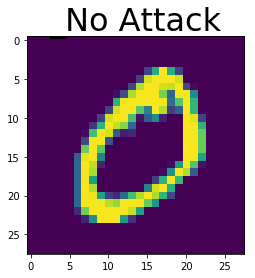

In [102]:
plot(adv_train['_No Attack'], 1, '_No Attack')

### Create and train baseline network

In [26]:
classifier = create_nn(min_, max_)
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=50)

Epoch 1/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0137 - acc: 0.9111
Epoch 2/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0065 - acc: 0.9587
Epoch 3/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0049 - acc: 0.9689
Epoch 4/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0041 - acc: 0.9744
Epoch 5/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0036 - acc: 0.9772


## Construct Adversarial Images on MNIST

In [100]:
results = defaultdict(dict)

adv_path = 'advs'
if not os.path.exists(adv_path):
   os.makedirs(adv_path)

In [63]:
compute = True

### Deepfool

In [29]:
if compute:
    %time adv_test['DeepFool'], adv_train['DeepFool'] = atk_DeepFool(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_DeepFool', adv_test['DeepFool'])
    np.save('adv/train_DeepFool', adv_train['DeepFool'])

In [30]:
adv_test['DeepFool'] = np.load('adv/test_DeepFool.npy')
adv_train['DeepFool'] = np.load('adv/train_DeepFool.npy')

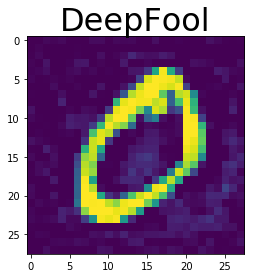

In [31]:
plot(adv_train['DeepFool'], 1, 'DeepFool')

### BasicIterative

In [32]:
if compute:
    %time adv_test['BasicIterative'], adv_train['BasicIterative'] = atk_BasicIterative(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_BasicIterative', adv_test['BasicIterative'])
    np.save('adv/train_BasicIterative', adv_train['BasicIterative'])

In [33]:
adv_test['BasicIterative'] = np.load('adv/test_BasicIterative.npy')
adv_train['BasicIterative'] = np.load('adv/train_BasicIterative.npy')

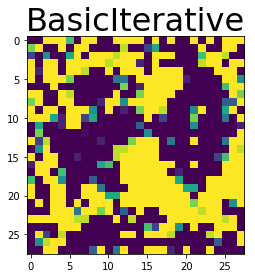

In [34]:
plot(adv_train['BasicIterative'], 1, 'BasicIterative')

### FGSM

In [69]:
if compute:
    %time adv_test['FGSM'], adv_train['FGSM'] = atk_FastGradient(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_FGSM', adv_test['FGSM'])
    np.save('adv/train_FGSM', adv_train['FGSM'])

Train: 14.12%
14.116666666666667
Test: 15.86%
CPU times: user 3.79 s, sys: 763 ms, total: 4.56 s
Wall time: 2.7 s


In [36]:
adv_test['FGSM'] = np.load('adv/test_FGSM.npy')
adv_train['FGSM'] = np.load('adv/train_FGSM.npy')

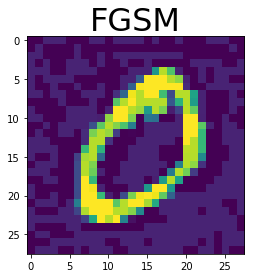

In [37]:
plot(adv_train['FGSM'], 1, 'FGSM')

### JSMA
Slow but strong adversarial examples. Preceded FGSM.

In [38]:
if compute:
    %time adv_test['JSMA'], adv_train['JSMA'] = atk_JSMA(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_JSMA', adv_test['JSMA'])
    np.save('adv/train_JSMA', adv_train['JSMA'])

In [39]:
adv_test['JSMA'] = np.load('adv/test_JSMA.npy')
adv_train['JSMA'] = np.load('adv/train_JSMA.npy')

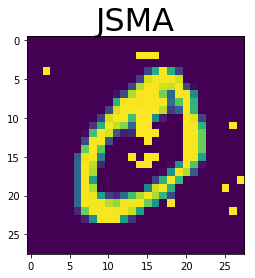

In [40]:
plot(adv_train['JSMA'], 1, 'JSMA')

### Carlini (L2)
Slow but considered one of the best iterative attacks.

In [41]:
if compute:
    %time adv_test['CarliniL2'], adv_train['CarliniL2'] = atk_CarliniL2(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_CarliniL2', adv_test['CarliniL2'])
    np.save('adv/train_CarliniL2', adv_train['CarliniL2'])

In [42]:
adv_test['CarliniL2'] = np.load('adv/test_CarliniL2.npy')
adv_train['CarliniL2'] = np.load('adv/train_CarliniL2.npy')

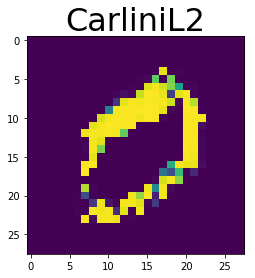

In [43]:
plot(adv_train['CarliniL2'], 1, 'CarliniL2')

### NewtonFool

In [44]:
if compute:
    %time adv_test['NewtonFool'], adv_train['NewtonFool'] = atk_NewtonFool(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_NewtonFool', adv_test['NewtonFool'])
    np.save('adv/train_NewtonFool', adv_train['NewtonFool'])

In [45]:
adv_test['NewtonFool'] = np.load('adv/test_NewtonFool.npy')
adv_train['NewtonFool'] = np.load('adv/train_NewtonFool.npy')

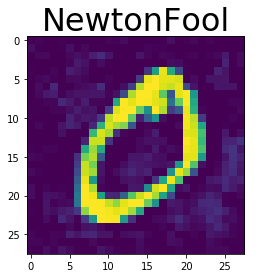

In [46]:
plot(adv_train['NewtonFool'], 1, 'NewtonFool')

### Universal Perturbation

In [47]:
if compute:
    %time adv_test['UniPerturb'], adv_train['UniPerturb'] = atk_UniPerturb(x_train, x_test, y_train, y_test, classifier)
    np.save('adv/test_UniPerturb', adv_test['UniPerturb'])
    np.save('adv/train_UniPerturb', adv_train['UniPerturb'])

In [48]:
adv_test['UniPerturb'] = np.load('adv/test_UniPerturb.npy')
adv_train['UniPerturb'] = np.load('adv/train_UniPerturb.npy')

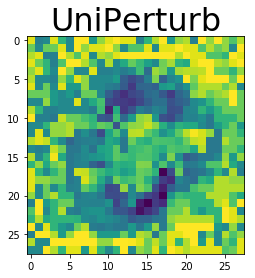

In [49]:
plot(adv_train['UniPerturb'], 1, 'UniPerturb')

In [50]:
def plot_all_adv(name, adv, start, end, height):
    assert(end > start)
    columns = len(adv.keys())
    rows = end - start
    fig = plt.figure(figsize=(15, rows*height))
    
    for row in range(rows):
        for col, attack in enumerate(adv.keys()):
            fig.add_subplot(rows, columns, (row * len(adv.keys())) + col + 1)
            img = extract_num(adv[attack], start + row)
            plt.imshow(img, interpolation='nearest')
            plt.title(attack, fontsize=12)
    fig.suptitle(name, fontsize=22)

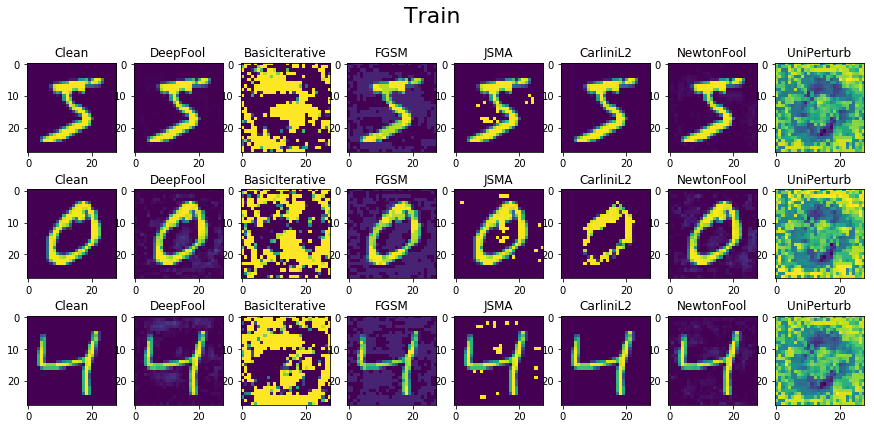

In [54]:
plot_all_adv('Train', adv_train, start=0, end=3, height=2.2)

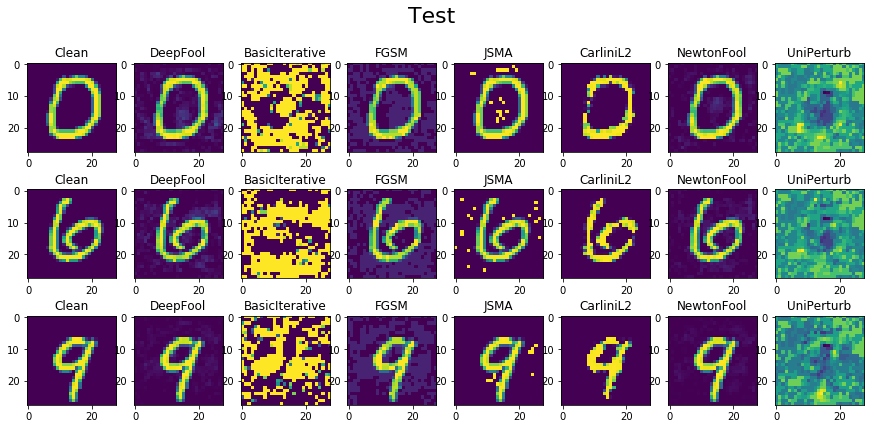

In [55]:
plot_all_adv('Test', adv_test, start=10, end=13, height=2.2)

## Benchmark Attacks against Defenses

In [103]:
evaluate(adv_train['_No Attack'], adv_test['_No Attack'], y_train, y_test, classifier, attack='_No Attack')
for attack in attack_list:
    evaluate(adv_train[attack], adv_test[attack], y_train, y_test, classifier, attack=attack)

[Evaluate] Attack: _No Attack Defense: No Defense
Train: 98.15%
Test: 97.08%
[Evaluate] Attack: DeepFool Defense: No Defense
Train: 91.54%
Test: 90.75%
[Evaluate] Attack: BasicIterative Defense: No Defense
Train: 13.73%
Test: 14.47%
[Evaluate] Attack: FGSM Defense: No Defense
Train: 14.12%
Test: 15.86%
[Evaluate] Attack: JSMA Defense: No Defense
Train: 70.20%
Test: 76.62%
[Evaluate] Attack: CarliniL2 Defense: No Defense
Train: 93.66%
Test: 60.77%
[Evaluate] Attack: NewtonFool Defense: No Defense
Train: 94.69%
Test: 93.73%
[Evaluate] Attack: UniPerturb Defense: No Defense
Train: 9.04%
Test: 8.92%


### Defense

In [88]:
x_train_adv_all = np.concatenate((adv_train['DeepFool'],
                            adv_train['BasicIterative'],
                            adv_train['FGSM'],
                            adv_train['JSMA'],
                            adv_train['CarliniL2'],
                            adv_train['NewtonFool'],
                            adv_train['UniPerturb']),
                            axis=0)

x_test_adv_all = np.concatenate((adv_test['DeepFool'],
                           adv_test['BasicIterative'],
                           adv_test['FGSM'],
                           adv_test['JSMA'],
                           adv_test['CarliniL2'],
                           adv_test['NewtonFool'],
                           adv_test['UniPerturb']),
                           axis=0)

In [107]:
def_SpatialSmoothing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0146 - acc: 0.9057
Epoch 2/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0078 - acc: 0.9503
Epoch 3/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0058 - acc: 0.9636
Epoch 4/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0049 - acc: 0.9692
Epoch 5/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0044 - acc: 0.9724
[Evaluate] Attack: DeepFool Defense: Spatial Smoothing
[Evaluate] Attack: BasicIterative Defense: Spatial Smoothing
[Evaluate] Attack: FGSM Defense: Spatial Smoothing
[Evaluate] Attack: JSMA Defense: Spatial Smoothing
[Evaluate] Attack: CarliniL2 Defense: Spatial Smoothing
[Evaluate] Attack: NewtonFool Defense: Spatial Smoothing
[Evaluate] Attack: UniPerturb Defense: Spatial Smoothing


In [108]:
def_AdversarialTraining(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
2400/2400 [==============================] - 6s 3ms/step - loss: 0.0103 - acc: 0.9329
Epoch 2/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0046 - acc: 0.9714
Epoch 3/5
2400/2400 [==============================] - 6s 2ms/step - loss: 0.0033 - acc: 0.9792
Epoch 4/5
2400/2400 [==============================] - 6s 2ms/step - loss: 0.0027 - acc: 0.9835
Epoch 5/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0022 - acc: 0.9864
[Evaluate] Attack: DeepFool Defense: Spatial Smoothing
Epoch 1/5
2400/2400 [==============================] - 6s 2ms/step - loss: 0.0103 - acc: 0.9350
Epoch 2/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0057 - acc: 0.9663
Epoch 3/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0049 - acc: 0.9715
Epoch 4/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0046 - acc: 0.9741
Epoch 5/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.0040

In [145]:
def_FeatureSqueezing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0137 - acc: 0.9102
Epoch 2/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0068 - acc: 0.9565
Epoch 3/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0051 - acc: 0.9685
Epoch 4/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0043 - acc: 0.9738
Epoch 5/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0036 - acc: 0.9775
[Evaluate] Attack: DeepFool Defense: Feature Squeezing
[Evaluate] Attack: BasicIterative Defense: Feature Squeezing
[Evaluate] Attack: FGSM Defense: Feature Squeezing
[Evaluate] Attack: JSMA Defense: Feature Squeezing
[Evaluate] Attack: CarliniL2 Defense: Feature Squeezing
[Evaluate] Attack: NewtonFool Defense: Feature Squeezing
[Evaluate] Attack: UniPerturb Defense: Feature Squeezing


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


In [110]:
def_LabelSmoothing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_)

Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0088 - acc: 0.9224
Epoch 2/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0048 - acc: 0.9672
Epoch 3/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0038 - acc: 0.9758
Epoch 4/5
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0032 - acc: 0.9819
Epoch 5/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0028 - acc: 0.9853
[Evaluate] Attack: DeepFool Defense: Label Smoothing
[Evaluate] Attack: BasicIterative Defense: Label Smoothing
[Evaluate] Attack: FGSM Defense: Label Smoothing
[Evaluate] Attack: JSMA Defense: Label Smoothing
[Evaluate] Attack: CarliniL2 Defense: Label Smoothing
[Evaluate] Attack: NewtonFool Defense: Label Smoothing
[Evaluate] Attack: UniPerturb Defense: Label Smoothing


In [133]:
def def_GaussianAugmentation(x_raw_train, x_raw_test, y_raw_train, y_raw_test, x_train_adv, x_test_adv, y_train, y_test, min_, max_):
    train_num = 60000
    test_num = 10000
    # gaussian augmentation
    ga = GaussianAugmentation(sigma=150)
    x_train_aug, y_train_aug = ga(x_raw_train, y_raw_train)
    x_test_aug, y_test_aug = ga(x_raw_test, y_raw_test)
    x_train_aug, y_train_aug = preprocess(x_train_aug, y_train_aug)
    x_test_aug, y_test_aug = preprocess(x_test_aug, y_test_aug)
    x_train_aug = x_train_aug.reshape(2*train_num, 784)
    x_test_aug = x_test_aug.reshape(2*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
    
    # print result
    for k in range (7):
        evaluate(x_train_adv[k*train_num:(k+1)*train_num],
                 x_test_adv[k*test_num:(k+1)*test_num],
                 y_train,
                 y_test,
                 classifier,
                 attack=attack_list[k],
                 defense="Gaussian Augmentation")

In [136]:
def_GaussianAugmentation(x_raw, x_raw_test, y_raw, y_raw_test, x_train_adv_all, x_test_adv_all, y_train, y_test, min_, max_)

Epoch 1/5
2400/2400 [==============================] - 8s 3ms/step - loss: 0.0184 - acc: 0.8745
Epoch 2/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0103 - acc: 0.9329
Epoch 3/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0081 - acc: 0.9483
Epoch 4/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0068 - acc: 0.9569
Epoch 5/5
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0059 - acc: 0.9625
[Evaluate] Attack: DeepFool Defense: Gaussian Augmentation
[Evaluate] Attack: BasicIterative Defense: Gaussian Augmentation
[Evaluate] Attack: FGSM Defense: Gaussian Augmentation
[Evaluate] Attack: JSMA Defense: Gaussian Augmentation
[Evaluate] Attack: CarliniL2 Defense: Gaussian Augmentation
[Evaluate] Attack: NewtonFool Defense: Gaussian Augmentation
[Evaluate] Attack: UniPerturb Defense: Gaussian Augmentation


# Results

In [146]:
results_df = pd.DataFrame(results)
results_df

,BasicIterative (Test),BasicIterative (Train),CarliniL2 (Test),CarliniL2 (Train),DeepFool (Test),DeepFool (Train),FGSM (Test),FGSM (Train),JSMA (Test),JSMA (Train),NewtonFool (Test),NewtonFool (Train),UniPerturb (Test),UniPerturb (Train),_No Attack (Test),_No Attack (Train)
Feature Squeezing,15.13,14.348333,67.88,93.681667,96.42,97.518333,94.46,94.973333,80.19,72.876667,96.52,97.593333,0.00,0.000000,NaN,NaN
Gaussian Augmentation,15.30,14.363333,79.28,95.175000,96.35,96.793333,89.05,88.365000,95.34,94.988333,96.48,96.841667,19.00,22.620000,NaN,NaN
Label Smoothing,13.91,13.215000,68.93,94.795000,90.07,91.046667,51.25,50.795000,74.03,72.553333,93.97,95.116667,14.71,17.091667,NaN,NaN
No Defense,14.47,13.730000,60.77,93.665000,90.75,91.536667,15.86,14.116667,76.62,70.200000,93.73,94.688333,8.92,9.035000,97.08,98.148333
Spatial Smoothing,96.60,97.526667,91.78,98.273333,97.51,98.785000,97.00,98.451667,92.26,98.910000,97.39,98.903333,17.41,88.791667,NaN,NaN


In [142]:
results_df.to_pickle('results/attack_defense_results.pkl')

Text(0.5,1,'No Defense')

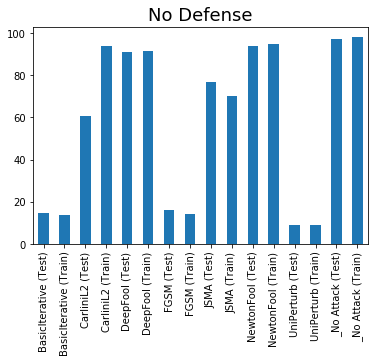

In [163]:
results_df.loc['No Defense'].plot.bar()
plt.title('No Defense', fontsize=18)

We see that BasicIterative (PGD), FGSM, and Universal Perturbation are extremely effective at lowering the accuracy of our trained classifiers. These methods were also extremely fast to converge.

Carlini and JSMA also significantly reduce the accuracy of the classifiers, however not to the same degree as PGD, FGSM, and Universal Perturbation. These methods are significantly costlier than the previous three methods, and so their strength may have been affected by our inability to optimally train them, given our time and resources.

Finally, DeepFool and NewtonFool (which is a derivative of DeepFool) have only a very slight effect on accuracy. This may be because DeepFool/NewtonFool require deeper and more powerful neural networks to properly generate adversarial images. Since we used shallow nets to compensate for the costly training process of these two methods, they may have not produced strong adversarial images.

In conclusion, we have three classes of adversarial attacks:
(1) Cheap attacks: PGD, FGSM, Universal Perturbation
(2) Expensive attacks: Carlini, JSMA
(3) Fool attacks: DeepFool, NewtonFool

Text(0.5,1,'Feature Squeezing')

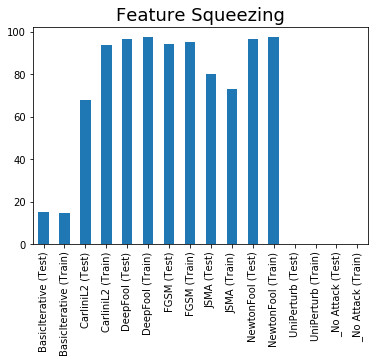

In [164]:
results_df.loc['Feature Squeezing'].plot.bar()
plt.title('Feature Squeezing',fontsize=18)

Feature squeezing seems to be an effective defense against FGSM, which was an especially strong (and easy-to-compute) attack. It is also a somewhat effective defense against JSMA, which was a more costly attack that resulted in not as strong adversarial attacks (perhaps as a result of insufficient training).

Text(0.5,1,'Gaussian Augmentation')

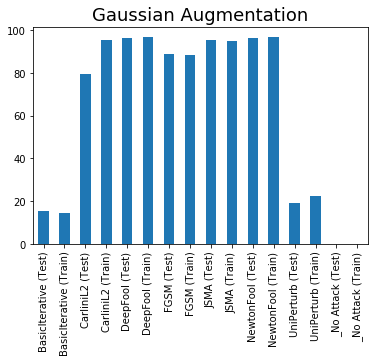

In [165]:
results_df.loc['Gaussian Augmentation'].plot.bar()
plt.title('Gaussian Augmentation',fontsize=18)

Gaussian augmentation also seems to be an effective defense against FGSM as well against JSMA. It also defends decently well on Carlini, increasing test accuracy by almost 20%.

Text(0.5,1,'Label Smoothing')

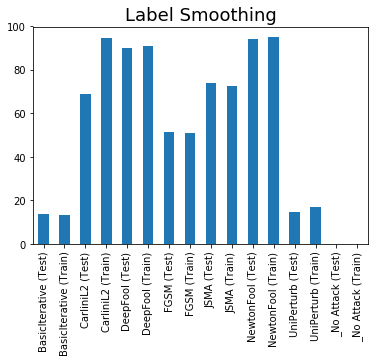

In [166]:
results_df.loc['Label Smoothing'].plot.bar()
plt.title('Label Smoothing', fontsize=18)

Label smoothing seems to be somewhat effective against FGSM.

Text(0.5,1,'Spatial Smoothing')

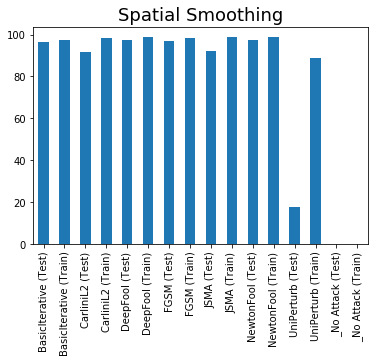

In [167]:
results_df.loc['Spatial Smoothing'].plot.bar()
plt.title('Spatial Smoothing', fontsize=18)

Spatial smoothing seems to be an extremely strong defense on all attacks except Universal Perturbation.

It is strong against PGD, Carlini, FGSM, as well as JSMA. 

It is the only defense that works on the training set of Universal Perturbation, but like all other defenses, fails in the test set.